<a href="https://colab.research.google.com/github/rickyray23/LearnGit4Dsc/blob/master/1_NN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [ ]:
init_df

,open,high,low,close,adjclose,volume,ticker
2019-09-09,60.354000,61.027500,59.658501,60.263500,60.263500,31854000,GOOGL
2019-09-10,59.804501,60.500000,59.800499,60.285000,60.285000,27922000,GOOGL
2019-09-11,60.194500,61.123501,60.113998,61.000000,61.000000,23522000,GOOGL
2019-09-12,61.173500,62.120998,61.127998,61.748501,61.748501,31644000,GOOGL
2019-09-13,61.605499,62.052502,61.354000,62.001499,62.001499,23676000,GOOGL
...,...,...,...,...,...,...,...
2022-09-12,110.989998,111.620003,109.930000,110.860001,110.860001,22966800,GOOGL
2022-09-13,107.800003,108.300003,104.089996,104.320000,104.320000,38172900,GOOGL
2022-09-14,104.570000,105.279999,103.660004,105.000000,105.000000,26395100,GOOGL
2022-09-15,104.029999,105.269997,102.349998,102.910004,102.910004,34188300,GOOGL


In [ ]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2019-09-09,60.263500,2019-09-09
2019-09-10,60.285000,2019-09-10
2019-09-11,61.000000,2019-09-11
2019-09-12,61.748501,2019-09-12
2019-09-13,62.001499,2019-09-13
...,...,...
2022-09-12,110.860001,2022-09-12
2022-09-13,104.320000,2022-09-13
2022-09-14,105.000000,2022-09-14
2022-09-15,102.910004,2022-09-15


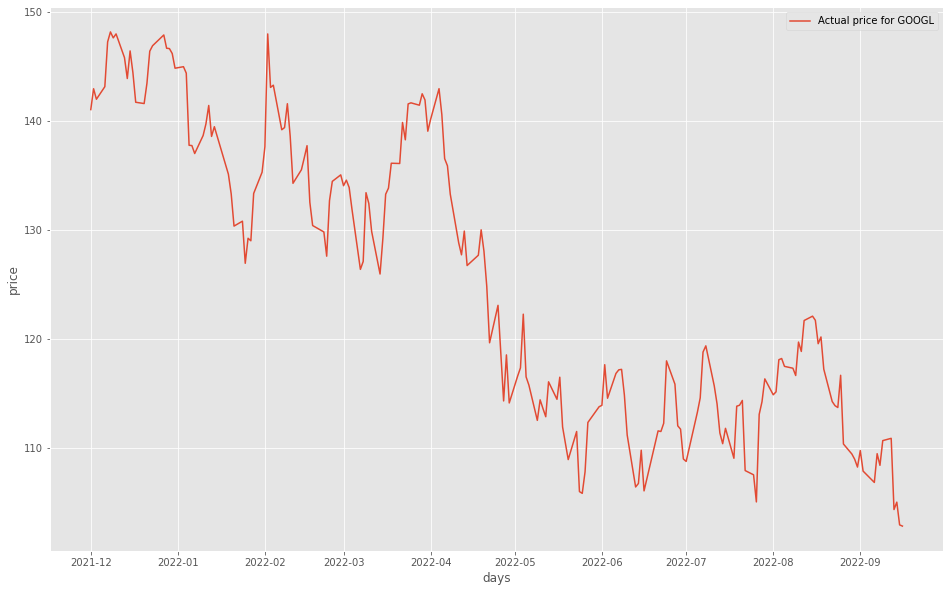

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2019-09-09,60.263500,2019-09-09,0.077801
2019-09-10,60.285000,2019-09-10,0.078023
2019-09-11,61.000000,2019-09-11,0.085384
2019-09-12,61.748501,2019-09-12,0.093090
2019-09-13,62.001499,2019-09-13,0.095694
...,...,...,...
2022-09-12,110.860001,2022-09-12,0.598706
2022-09-13,104.320000,2022-09-13,0.531375
2022-09-14,105.000000,2022-09-14,0.538376
2022-09-15,102.910004,2022-09-15,0.516859


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2019-09-09   60.263500 2019-09-09      0.077801  0.093090
 2019-09-10   60.285000 2019-09-10      0.078023  0.095694
 2019-09-11   61.000000 2019-09-11      0.085384  0.091371
 2019-09-12   61.748501 2019-09-12      0.093090  0.090470
 2019-09-13   62.001499 2019-09-13      0.095694  0.091896
 ...                ...        ...           ...       ...
 2022-09-07  109.449997 2022-09-07      0.584190  0.598706
 2022-09-08  108.379997 2022-09-08      0.573174  0.531375
 2022-09-09  110.650002 2022-09-09      0.596544  0.538376
 2022-09-12  110.860001 2022-09-12      0.598706  0.516859
 2022-09-13  104.320000 2022-09-13      0.531375  0.515726
 
 [760 rows x 4 columns], array([[0.5677171 ],
        [0.55701   ],
        [0.58418953],
        [0.5731736 ],
        [0.5965439 ],
        [0.5987059 ],
        [0.5313748 ],
        [0.5383756 ],
        [0.5168585 ],
        [0.51572603]], dtype=float32), array([[[0.07780133435857672,

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 9s 22ms/step - loss: 0.0236
Epoch 2/80
95/95 [==============================] - 2s 21ms/step - loss: 0.0046
Epoch 3/80
95/95 [==============================] - 2s 23ms/step - loss: 0.0039
Epoch 4/80
95/95 [==============================] - 2s 24ms/step - loss: 0.0044
Epoch 5/80
95/95 [==============================] - 2s 26ms/step - loss: 0.0030
Epoch 6/80
95/95 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 7/80
95/95 [==============================] - 2s 26ms/step - loss: 0.0025
Epoch 8/80
95/95 [==============================] - 2s 21ms/step - loss: 0.0024
Epoch 9/80
95/95 [==============================] - 2s 17ms/step - loss: 0.0025
Epoch 10/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 11/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 12/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0028
Epoch 13/80
95/95 [==================

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

GOOGL prediction for upcoming 3 days (105.28$, 102.99$, 105.27$)


In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

In [ ]:
copy_df

,close,date,scaled_close,predicted_close
2019-09-09,60.263500,2019-09-09,0.077801,61.492001
2019-09-10,60.285000,2019-09-10,0.078023,61.734501
2019-09-11,61.000000,2019-09-11,0.085384,60.916500
2019-09-12,61.748501,2019-09-12,0.093090,62.297001
2019-09-13,62.001499,2019-09-13,0.095694,62.114498
...,...,...,...,...
2022-09-12,110.860001,2022-09-12,0.598706,110.839371
2022-09-13,104.320000,2022-09-13,0.531375,111.554169
2022-09-14,105.000000,2022-09-14,0.538376,109.301186
2022-09-15,102.910004,2022-09-15,0.516859,102.910004


In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


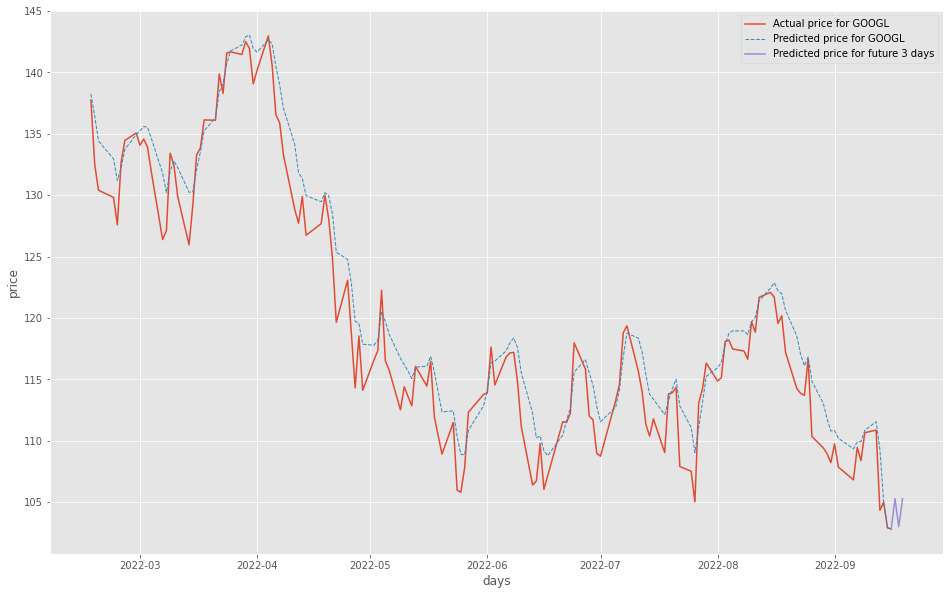

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()